Map: 100%|██████████| 1586/1586 [00:00<?, ? examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 28120.30 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_6988\1432834948.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `process

Step,Training Loss
100,0.962100
200,0.808900
300,0.769600
400,0.721500
500,0.714400
600,0.731100
700,0.708400
800,0.715900
900,0.577700
1000,0.577700


Validation Results: {'eval_loss': 1.2482432126998901, 'eval_accuracy': 0.7645181876196554, 'eval_f1': 0.7628632443040219, 'eval_runtime': 2.8736, 'eval_samples_per_second': 545.303, 'eval_steps_per_second': 34.103, 'epoch': 8.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.58      0.49      0.53       361
    Positive       0.80      0.83      0.81       654
    Negative       0.78      0.82      0.80       571

    accuracy                           0.75      1586
   macro avg       0.72      0.71      0.71      1586
weighted avg       0.74      0.75      0.74      1586



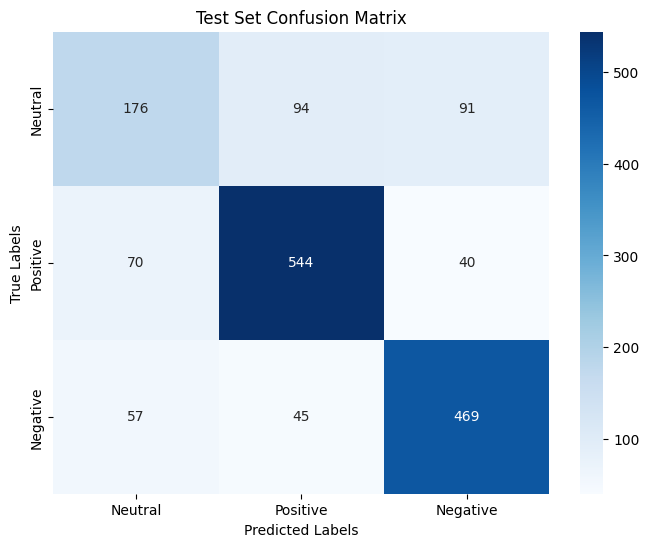

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from transformers import TrainingArguments


# Load datasets
train_df = pd.read_csv("D:\cse465_Pro\Train.csv")
test_df = pd.read_csv("D:\cse465_Pro\Test.csv")
val_df = pd.read_csv("D:\cse465_Pro\Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Check for missing values and shuffle
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
val_df.dropna(inplace=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    # evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy='epoch',
    # load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],  # Use validation set for evaluation
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model on validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final evaluation on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [3]:
trainer.save_model('BanglaBERT_Model')

Map: 100%|██████████| 1586/1586 [00:00<00:00, 93370.29 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 33913.32 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_13332\2516724338.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`.

Step,Training Loss
10,1.078900
20,1.071000
30,1.017900
40,1.003400
50,0.893600
60,0.869400
70,0.865600
80,0.764700
90,0.853600
100,0.890100


Validation Results: {'eval_loss': 1.1300071477890015, 'eval_accuracy': 0.7657945118059988, 'eval_f1': 0.7625211625908024, 'eval_runtime': 5.0759, 'eval_samples_per_second': 308.715, 'eval_steps_per_second': 9.653, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.55      0.44      0.49       361
    Positive       0.78      0.83      0.81       654
    Negative       0.78      0.82      0.80       571

    accuracy                           0.74      1586
   macro avg       0.70      0.70      0.70      1586
weighted avg       0.73      0.74      0.73      1586



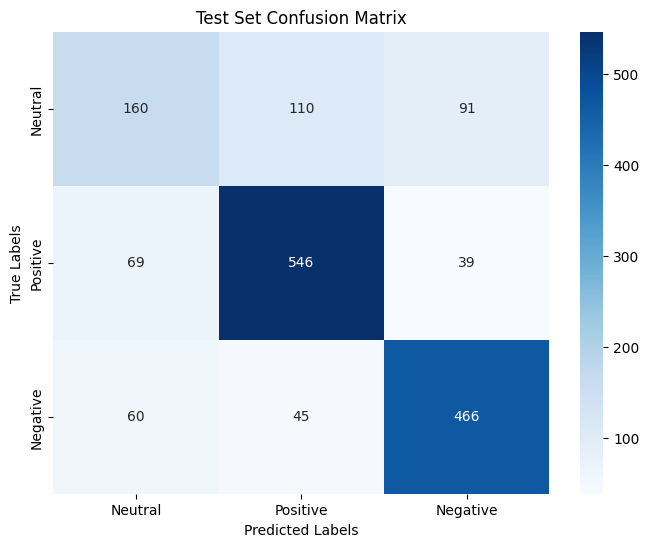

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Drop missing and shuffle
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
val_df.dropna(inplace=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Hugging Face Dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# # Training Arguments (No incompatible keys)

training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
    # Removed evaluation_strategy, save_strategy, etc.
)


# Optimizer and LR scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = (len(dataset["train"]) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    optimizers=(optimizer, lr_scheduler)
)

# Training
trainer.train()

# Validation evaluation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final test evaluation
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [3]:
trainer.save_model('BanglaBERT_Model_2')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 34320.12 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

trainable params: 887,811 || all params: 111,507,462 || trainable%: 0.7962


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,1.080800
20,1.061900
30,1.038700
40,1.052400
50,0.980400
60,0.888300
70,0.838000
80,0.805000
90,0.757300
100,0.837500


Validation Results: {'eval_loss': 0.6592229008674622, 'eval_accuracy': 0.7319719208679004, 'eval_f1': 0.725679775565163, 'eval_runtime': 1.2371, 'eval_samples_per_second': 1266.719, 'eval_steps_per_second': 39.61, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.56      0.42      0.48       361
    Positive       0.78      0.81      0.80       654
    Negative       0.76      0.84      0.80       571

    accuracy                           0.74      1586
   macro avg       0.70      0.69      0.69      1586
weighted avg       0.72      0.74      0.73      1586



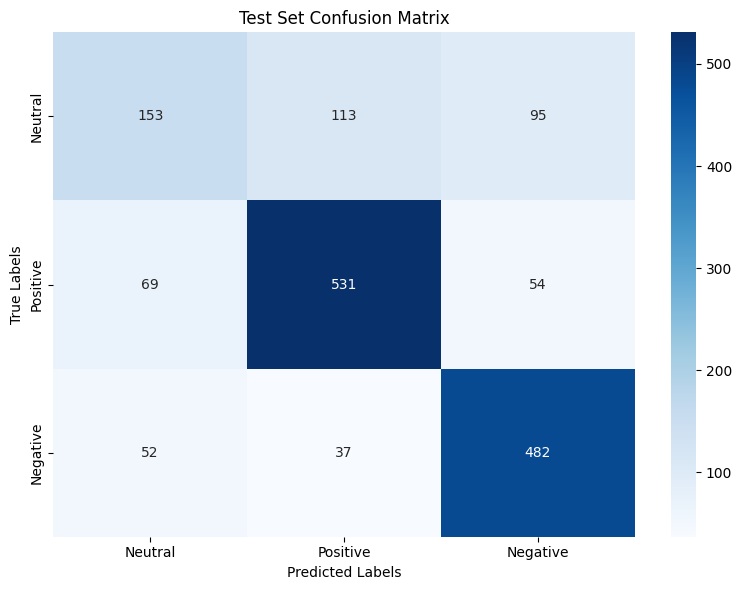

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Load base model (no quantization)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list)
)

# Apply LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_steps=500,  # Older versions save checkpoints this way
    save_total_limit=2,  # Optional: to limit number of saved checkpoints
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    learning_rate=2e-4
)

# Note: You'll need to manually implement evaluation and saving if you're using an older version.


# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [2]:
trainer.save_model('BanglaBERT_Model_3')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 29419.78 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Step,Training Loss
10,1.090300
20,0.946300
30,0.955600
40,0.919000
50,0.893200
60,0.918200
70,0.905000
80,0.883300
90,0.795800
100,0.899200


Validation Results: {'eval_loss': 1.0709023475646973, 'eval_accuracy': 0.39757498404594765, 'eval_f1': 0.2262001964023976, 'eval_runtime': 1.1887, 'eval_samples_per_second': 1318.28, 'eval_steps_per_second': 41.223, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       361
    Positive       0.41      1.00      0.58       654
    Negative       0.00      0.00      0.00       571

    accuracy                           0.41      1586
   macro avg       0.14      0.33      0.19      1586
weighted avg       0.17      0.41      0.24      1586



c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


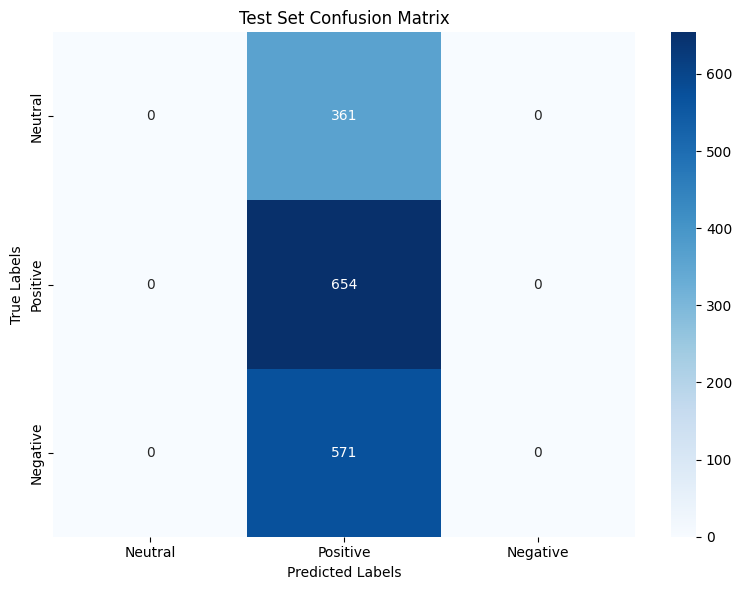

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Load model for full fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list)
)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    learning_rate=2e-4
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 34943.54 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_5568\1307569910.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-14 2

Step,Training Loss
10,1.095200
20,1.020300
30,0.915600
40,1.071200
50,1.027800
60,0.944500
70,0.976400
80,0.997600
90,1.057500
100,0.778700


[I 2025-04-14 21:50:57,354] Trial 0 finished with value: 0.759295395912968 and parameters: {'learning_rate': 0.00010257028070108587, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.0590586709777104}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.153000
20,1.093300
30,1.056900
40,1.071300
50,1.080300
60,1.048000
70,1.073100
80,1.117500
90,1.086900
100,1.028200


[I 2025-04-14 21:56:15,641] Trial 1 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00036255933572168465, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.2955977075046687}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.096800
20,1.040200
30,0.953800
40,0.892700
50,1.030400
60,0.833400
70,0.961400
80,1.010900
90,1.089000
100,0.894100


[I 2025-04-14 22:08:47,585] Trial 2 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00011491465214812784, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.08075802415142698}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.089900
20,1.058600
30,1.004300
40,0.959800
50,0.901400
60,0.889500
70,0.958300
80,0.942200
90,1.004200
100,0.765300


[I 2025-04-14 22:17:15,912] Trial 3 finished with value: 0.7598224584437565 and parameters: {'learning_rate': 3.176958105824071e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 16, 'weight_decay': 0.13593381966039556}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.110100
20,1.029600
30,1.069300
40,1.108400
50,1.067300
60,1.080300
70,1.053100
80,1.089300
90,1.055200
100,1.110200


[I 2025-04-14 22:24:43,973] Trial 4 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00026557434913060336, 'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'weight_decay': 0.07592664117293944}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.126700
20,1.087400
30,1.054500
40,1.059200
50,1.073000
60,1.046300
70,1.068900
80,1.103600
90,1.091400
100,1.025600


[I 2025-04-14 22:29:36,318] Trial 5 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0002554630910364573, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.16311932475371935}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.121800
20,1.065300
30,1.071200
40,1.121700
50,1.090600
60,1.079500
70,1.060700
80,1.085400
90,1.055500
100,1.109500


[I 2025-04-14 22:31:55,204] Trial 6 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0004190266453773946, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.09159194676541724}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.111500
20,1.057600
30,0.978400
40,1.023300
50,0.963600
60,0.965100
70,0.953000
80,1.001200
90,1.075300
100,1.043000


[I 2025-04-14 22:36:44,289] Trial 7 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00018718434436944883, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.1801993741679746}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.137700
20,1.099500
30,1.070200
40,1.080500
50,1.080500
60,1.043000
70,1.063000
80,1.115200
90,1.088400
100,1.025600


[I 2025-04-14 22:42:44,345] Trial 8 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00035535219618998393, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.050379109105615445}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.069100
20,0.903800
30,0.873100
40,0.912900
50,0.818800
60,0.823000
70,0.884200
80,0.872900
90,0.797600
100,0.882600


[I 2025-04-14 22:46:30,980] Trial 9 finished with value: 0.7535279360052035 and parameters: {'learning_rate': 9.54639020373387e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.19465953670324415}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Step,Training Loss
10,1.089900
20,1.058700
30,1.004300
40,0.959700
50,0.901100
60,0.878800
70,0.931900
80,0.855800
90,0.975500
100,0.679400


Validation Results: {'eval_loss': 1.2230056524276733, 'eval_accuracy': 0.7619655392469687, 'eval_f1': 0.7590450998097483, 'eval_runtime': 4.6782, 'eval_samples_per_second': 334.961, 'eval_steps_per_second': 41.897, 'epoch': 7.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.58      0.47      0.52       361
    Positive       0.80      0.83      0.81       654
    Negative       0.78      0.84      0.81       571

    accuracy                           0.75      1586
   macro avg       0.72      0.71      0.72      1586
weighted avg       0.74      0.75      0.75      1586



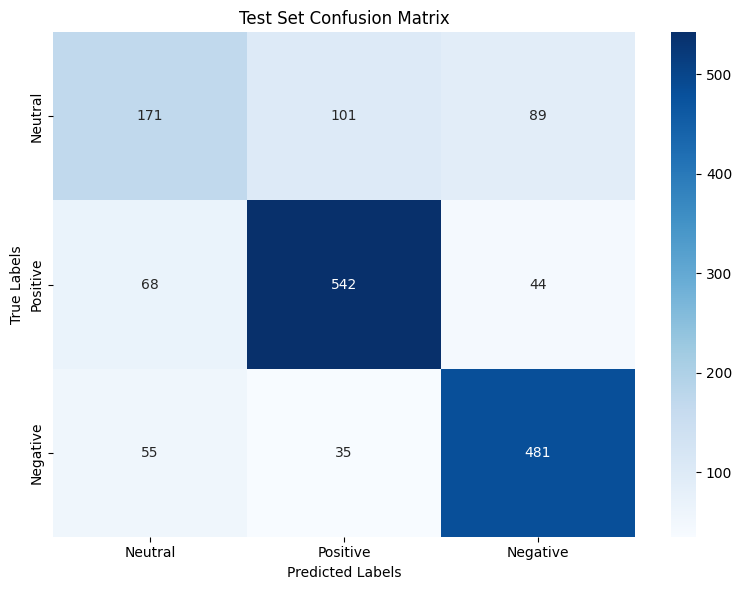

In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import optuna

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Define model init function for optuna
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_list)
    )

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Define Trainer
trainer = Trainer(
    model_init=model_init,  # ✅ required for hyperparameter search
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Hyperparameter space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# Run hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=10
)

# Apply best hyperparameters
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

# Rebuild model with best params
trainer.model = model_init()

# Train with best hyperparameters
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()



In [7]:
trainer.save_model('BanglaBERT_Model_4')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\AppData\Local\Temp\ipykernel_7060\3220979306.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
Map: 100%|██████████| 1586/1586 [00:00<00:00, 13023.32 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Step,Training Loss
50,1.043800
100,0.900700
150,0.825200
200,0.806300
250,0.814000
300,0.766700
350,0.770500
400,0.729500
450,0.702300
500,0.691100


Validation Results: {'eval_loss': 1.4430829286575317, 'eval_accuracy': 0.7638800255264837, 'eval_f1': 0.7627137449620263, 'eval_runtime': 4.2995, 'eval_samples_per_second': 364.459, 'eval_steps_per_second': 22.793, 'epoch': 10.0}
Test Classification Report:
               precision    recall  f1-score   support

     Neutral       0.56      0.48      0.52       361
    Positive       0.79      0.82      0.80       654
    Negative       0.79      0.81      0.80       571

    accuracy                           0.74      1586
   macro avg       0.71      0.71      0.71      1586
weighted avg       0.73      0.74      0.74      1586



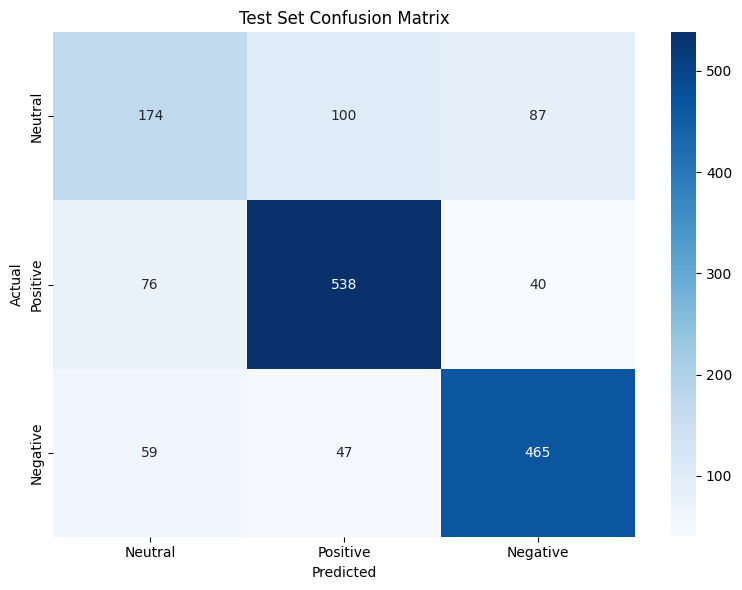

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# ========== Load CSVs ==========
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

# ========== Label Mapping ==========
label_to_id = {"Neutral": 0, "Positive": 1, "Negative": 2}
id_to_label = {v: k for k, v in label_to_id.items()}
label_list = list(label_to_id.keys())

# Map string labels to integers
for df in [train_df, test_df, val_df]:
    df = df[df["Label"].isin(label_to_id)]  # Ensure only known labels
    df["Label"] = df["Label"].map(label_to_id)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

# ========== Convert to Hugging Face Dataset ==========
def convert_to_dataset(df):
    return Dataset.from_pandas(df[["Data", "Label"]].rename(columns={"Data": "text", "Label": "label"}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# ========== Tokenization ==========
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).with_format("torch")

# ========== Load and Prepare Model ==========
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_id),
    id2label=id_to_label,
    label2id=label_to_id
)

# Fine-tune all layers
for param in model.base_model.parameters():
    param.requires_grad = True

# ========== Metrics ==========
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# ========== TrainingArguments ==========
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    # load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available()
)

# ========== Trainer ==========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ========== Train ==========
trainer.train()

# ========== Evaluate ==========
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# ========== Test Prediction ==========
test_output = trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# ========== Report ==========
print("Test Classification Report:\n", classification_report(test_labels, test_preds, target_names=label_list))

# ========== Confusion Matrix ==========
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [2]:
trainer.save_model("BanglaBERT_Model_5")

In [1]:
import os
import random
import torch
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, val_df, test_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({"text": df["Data"], "label": df["Label"]}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df),
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[l] for l in x["label"]]}, batched=True)

# Tokenize
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).rename_column("label", "labels")
dataset.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_list)
    )

# Initial args (no save of optimizer/scheduler to avoid error)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_only_model=True,   
)

# Optuna space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"])
    }

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=15,
)

# Update args with best trial
best_args = training_args
for key, value in best_run.hyperparameters.items():
    setattr(best_args, key, value)

# Final Trainer with best args and early stopping
final_trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics_1=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train with best setup
final_trainer.train()

# Evaluation
val_results = final_trainer.evaluate()
print("Validation Results:", val_results)

# Test
test_output = final_trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_preds, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 1586/1586 [00:00<00:00, 27962.26 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_16296\2831153694.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-24 11:30:50,261] A new study created in memory with name: no-name-acbec70

Step,Training Loss
100,1.079700
200,0.961600
300,0.845000
400,0.795300
500,0.740000
600,0.744000
700,0.713500
800,0.714500
900,0.621400
1000,0.559100


[I 2025-04-24 11:41:18,914] Trial 0 finished with value: 0.7573513639030397 and parameters: {'learning_rate': 2.906951970512147e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 16, 'weight_decay': 0.08590049473408559, 'warmup_ratio': 0.08446342437065482, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7573513639030397.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.988400
200,1.086900
300,1.087600
400,1.076600
500,1.073300
600,1.068500
700,1.075600
800,1.081800
900,1.081900
1000,1.078300


[I 2025-04-24 11:46:02,562] Trial 1 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0001171952522665622, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.02448786635409118, 'warmup_ratio': 0.03202218005821755, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7573513639030397.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.052800
200,0.863100
300,0.839200
400,0.792700
500,0.739900
600,0.733300
700,0.705500
800,0.702100
900,0.576600
1000,0.529000


[I 2025-04-24 11:50:44,726] Trial 2 finished with value: 0.7630408048507232 and parameters: {'learning_rate': 4.296153398512601e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.17020924870487406, 'warmup_ratio': 0.07542481057456525, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.981300
200,0.912300
300,1.017300
400,1.080100
500,1.077000
600,1.069500
700,1.076500
800,1.080900
900,1.082700
1000,1.077800


[I 2025-04-24 12:00:03,731] Trial 3 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0004206289126972995, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.048777079973626826, 'warmup_ratio': 0.06546539361751356, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.094100
200,1.077800
300,1.057700
400,0.956400
500,0.851700
600,0.821400
700,0.768100
800,0.784500
900,0.721300
1000,0.685500


[I 2025-04-24 12:11:42,714] Trial 4 finished with value: 0.7578402242206319 and parameters: {'learning_rate': 2.5553603665014905e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.06282378168554816, 'warmup_ratio': 0.2908330116638783, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.093300
200,1.075100
300,1.045900
400,0.926100
500,0.831600
600,0.807200
700,0.756900
800,0.776800
900,0.708900
1000,0.673300


[I 2025-04-24 12:22:12,950] Trial 5 finished with value: 0.7483288298495991 and parameters: {'learning_rate': 2.105292120962438e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.24390344998210833, 'warmup_ratio': 0.22599638779542783, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.005400
200,0.885500
300,0.891700
400,0.850300
500,0.897900
600,0.886600
700,0.937300
800,0.878000
900,0.790400
1000,0.723400


[I 2025-04-24 12:28:01,708] Trial 6 finished with value: 0.7437437554062555 and parameters: {'learning_rate': 9.158616298701835e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.04918519371903902, 'warmup_ratio': 0.029992245189682465, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.080800
200,0.974600
300,0.848400
400,0.799900
500,0.744900
600,0.769900
700,0.729200
800,0.735100
900,0.639000
1000,0.596500


[I 2025-04-24 12:33:52,474] Trial 7 finished with value: 0.7548854760256234 and parameters: {'learning_rate': 4.192342438961124e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.19512138302070195, 'warmup_ratio': 0.1861301056015884, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.066300
200,0.879600
300,0.835200
400,0.811200
500,0.762200
600,0.771300
700,0.768000
800,0.787200
900,0.726300
1000,0.714500


[I 2025-04-24 12:43:12,739] Trial 8 finished with value: 0.7557366107561223 and parameters: {'learning_rate': 0.00011014550957865002, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.15223915035014216, 'warmup_ratio': 0.13561126562007172, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.072800
200,0.892500
300,0.778600
400,0.733800
500,0.637400
600,0.649100
700,0.643700
800,0.662400
900,0.469300
1000,0.521500


[I 2025-04-24 12:49:48,870] Trial 9 finished with value: 0.7579154724389764 and parameters: {'learning_rate': 8.058567665358108e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 32, 'weight_decay': 0.23445300981925885, 'warmup_ratio': 0.28797193153127865, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.943500
200,0.832300
300,0.820700
400,0.829400
500,0.787700
600,0.792500
700,0.761900
800,0.734400
900,0.637600
1000,0.651800


[I 2025-04-24 12:54:14,081] Trial 10 finished with value: 0.7409779803719323 and parameters: {'learning_rate': 0.0002474995532990357, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.13043075713512495, 'warmup_ratio': 0.1297929727412698, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.079900
200,0.938800
300,0.795100
400,0.744300
500,0.661500
600,0.656800
700,0.648800
800,0.654800
900,0.491700
1000,0.526600


[I 2025-04-24 13:01:33,969] Trial 11 finished with value: 0.7490642676065239 and parameters: {'learning_rate': 6.390043551039434e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'weight_decay': 0.2930750958856715, 'warmup_ratio': 0.29338120064836337, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.071700
200,0.888600
300,0.775600
400,0.732700
500,0.630200
600,0.645000
700,0.642100
800,0.643100
900,0.448500
1000,0.462800


[I 2025-04-24 13:06:42,810] Trial 12 finished with value: 0.7612642065509676 and parameters: {'learning_rate': 5.2718714618643184e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'weight_decay': 0.21322500451368617, 'warmup_ratio': 0.2326650920060953, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.048100
200,0.834500
300,0.767700
400,0.720400
500,0.602200
600,0.612100
700,0.589300
800,0.584700
900,0.376500
1000,0.392000


[I 2025-04-24 13:09:41,390] Trial 13 finished with value: 0.7597438359739285 and parameters: {'learning_rate': 4.620350401491985e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.1761011284272692, 'warmup_ratio': 0.21869566091880271, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7630408048507232.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.024300
200,0.824200
300,0.763300
400,0.711300
500,0.582400
600,0.595500
700,0.564300
800,0.561300
900,0.373300
1000,0.382000


[I 2025-04-24 13:14:07,180] Trial 14 finished with value: 0.7559668906899866 and parameters: {'learning_rate': 4.558146288425106e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.11131031813740938, 'warmup_ratio': 0.10038041251384097, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7630408048507232.
C:\Users\User\AppData\Local\Temp\ipykernel_16296\2831153694.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


TypeError: Trainer.__init__() got an unexpected keyword argument 'compute_metrics_1'

In [2]:
import os
import random
import torch
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, val_df, test_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({"text": df["Data"], "label": df["Label"]}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df),
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[l] for l in x["label"]]}, batched=True)

# Tokenize
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).rename_column("label", "labels")
dataset.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_list)
    )

# Initial args (no save of optimizer/scheduler to avoid error)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_only_model=True,   
)

# Optuna space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"])
    }

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=5,
)

# Update args with best trial
best_args = training_args
for key, value in best_run.hyperparameters.items():
    setattr(best_args, key, value)

# Final Trainer with best args and early stopping
final_trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    
)

# Train with best setup
final_trainer.train()

# Evaluation
val_results = final_trainer.evaluate()
print("Validation Results:", val_results)

# Test
test_output = final_trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_preds, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Map: 100%|██████████| 1586/1586 [00:00<00:00, 38758.31 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_16296\756850219.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-24 13:19:53,460] A new study created in memory with name: no-name-affe662d-ae36-491f-bd21-47c9211dd6d1
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias'

Step,Training Loss
100,1.078500
200,0.948300
300,0.839300
400,0.798100
500,0.740800
600,0.766000
700,0.726200
800,0.738900
900,0.663600
1000,0.618700


[I 2025-04-24 13:33:21,252] Trial 0 finished with value: 0.7607547497171144 and parameters: {'learning_rate': 5.5523258499616634e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.19257946299110745, 'warmup_ratio': 0.11460336693312123, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.7607547497171144.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.999200
200,0.991200
300,1.091500
400,1.077500
500,1.075700
600,1.069700
700,1.077200
800,1.082700
900,1.082600
1000,1.078100


[I 2025-04-24 13:45:59,484] Trial 1 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00048296647626532854, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.19022546715449648, 'warmup_ratio': 0.08144216942741923, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7607547497171144.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.071600
200,0.888100
300,0.775600
400,0.730800
500,0.630500
600,0.630900
700,0.616200
800,0.613200
900,0.415800
1000,0.436200


[I 2025-04-24 13:48:58,384] Trial 2 finished with value: 0.7520402796032998 and parameters: {'learning_rate': 3.611072925817237e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.10126259161904917, 'warmup_ratio': 0.277946549507678, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.7607547497171144.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.082700
200,0.967300
300,0.809200
400,0.758300
500,0.675300
600,0.672600
700,0.666500
800,0.674300
900,0.516400
1000,0.528600


[I 2025-04-24 13:54:07,331] Trial 3 finished with value: 0.7566336200477398 and parameters: {'learning_rate': 3.684331828536101e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'weight_decay': 0.14486718756774444, 'warmup_ratio': 0.2959710048382773, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.7607547497171144.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.066600
200,0.869200
300,0.774600
400,0.730300
500,0.627100
600,0.646100
700,0.642300
800,0.660500
900,0.455700
1000,0.495100


[I 2025-04-24 14:00:00,750] Trial 4 finished with value: 0.7558246214154348 and parameters: {'learning_rate': 6.590194241309621e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'weight_decay': 0.046833909288738824, 'warmup_ratio': 0.21903163557586444, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.7607547497171144.
C:\Users\User\AppData\Local\Temp\ipykernel_16296\756850219.py:131: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were no

AssertionError: EarlyStoppingCallback requires IntervalStrategy of steps or epoch

Map: 100%|██████████| 1586/1586 [00:00<00:00, 30281.72 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_16296\494930362.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-24 14:09:11,437] A new study created in memory with name: no-name-00581d0d-1f2e-457c-8350-694cb121f6c5
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias'

Step,Training Loss
100,1.036600
200,0.826000
300,0.764500
400,0.730900
500,0.620000
600,0.662800
700,0.630300
800,0.626100
900,0.414800
1000,0.442400


[I 2025-04-24 14:13:44,744] Trial 0 finished with value: 0.754532773558138 and parameters: {'learning_rate': 8.236479147169e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.21912308644276574, 'warmup_ratio': 0.21890357813815378, 'lr_scheduler_type': 'polynomial'}. Best is trial 0 with value: 0.754532773558138.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.084100
200,1.012700
300,0.871000
400,0.817400
500,0.759200
600,0.764300
700,0.719000
800,0.744200
900,0.644500
1000,0.586700


[I 2025-04-24 14:23:10,797] Trial 1 finished with value: 0.7533651552332467 and parameters: {'learning_rate': 3.4365998412749706e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.015514810416683244, 'warmup_ratio': 0.12659665260416306, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.754532773558138.
C:\Users\User\AppData\Local\Temp\ipykernel_16296\494930362.py:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were no

Step,Training Loss
100,1.036600
200,0.826000
300,0.764500
400,0.730900
500,0.620000
600,0.662800
700,0.630300
800,0.626100
900,0.414800
1000,0.442400


Validation Results: {'eval_loss': 0.9818196892738342, 'eval_accuracy': 0.7555839183152521, 'eval_f1': 0.754532773558138, 'eval_runtime': 2.7597, 'eval_samples_per_second': 567.819, 'eval_steps_per_second': 71.023, 'epoch': 6.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.59      0.51      0.55       361
    Positive       0.81      0.82      0.81       654
    Negative       0.79      0.84      0.82       571

    accuracy                           0.76      1586
   macro avg       0.73      0.73      0.73      1586
weighted avg       0.75      0.76      0.75      1586



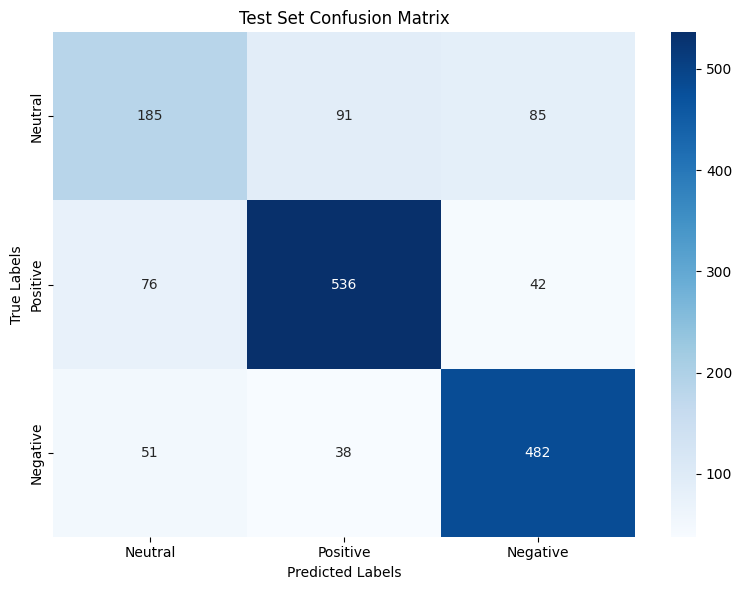

In [3]:
import os
import random
import torch
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed()

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, val_df, test_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({"text": df["Data"], "label": df["Label"]}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df),
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[l] for l in x["label"]]}, batched=True)

# Tokenization
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).rename_column("label", "labels")
dataset.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_list)
    )

# Training arguments for search (minimal settings)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

# Hyperparameter space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"]),
    }

# Trainer for Optuna search
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Hyperparameter tuning
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=2,
)

# Final training arguments
best_training_args = TrainingArguments(
    output_dir="./best_results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
    **best_run.hyperparameters,
)

# Final trainer with best setup (no early stopping)
final_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Train
final_trainer.train()

# Validation results
val_results = final_trainer.evaluate()
print("Validation Results:", val_results)

# Test prediction
test_output = final_trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_preds, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [7]:
final_trainer.save_model('BanglaBERT_Model_6')

Map: 100%|██████████| 1586/1586 [00:00<00:00, 35061.96 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_16296\2045571851.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-24 14:35:34,114] A new study created in memory with name: no-name-457c4a51-db76-48c2-8a2c-3c0f555b5220
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias

Step,Training Loss
100,1.065000
200,0.874300
300,0.826300
400,0.823100
500,0.769800
600,0.780100
700,0.763900
800,0.810600
900,0.706500
1000,0.746000


[I 2025-04-24 14:51:10,400] Trial 0 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0002900697014118122, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.03170921561925568, 'warmup_ratio': 0.27440113996126225, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.2262001964023976.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.069100
200,1.081300
300,1.070800
400,1.078300
500,1.080800
600,1.071300
700,1.069000
800,1.073100
900,1.070400
1000,1.070700


[I 2025-04-24 14:55:22,858] Trial 1 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0004738765034172313, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'weight_decay': 0.17200467018150478, 'warmup_ratio': 0.05416562046465135, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.2262001964023976.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.030600
200,0.815500
300,0.767600
400,0.734000
500,0.608400
600,0.660300
700,0.649400
800,0.632500
900,0.435400
1000,0.463100


[I 2025-04-24 15:02:33,537] Trial 2 finished with value: 0.7600279931434799 and parameters: {'learning_rate': 0.00010204649472394728, 'num_train_epochs': 8, 'per_device_train_batch_size': 32, 'weight_decay': 0.29596910505538787, 'warmup_ratio': 0.18449633753574116, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.073000
200,0.905100
300,0.834000
400,0.789500
500,0.741800
600,0.767500
700,0.735600
800,0.748300
900,0.668300
1000,0.646200


[I 2025-04-24 15:13:12,701] Trial 3 finished with value: 0.35686334427312527 and parameters: {'learning_rate': 0.00018114852502535564, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.01185024461601637, 'warmup_ratio': 0.26406873978237405, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.086900
200,1.042800
300,0.899100
400,0.825600
500,0.764300
600,0.765700
700,0.724800
800,0.753100
900,0.658800
1000,0.618400


[I 2025-04-24 15:25:02,898] Trial 4 finished with value: 0.7500024412763368 and parameters: {'learning_rate': 5.081963224336728e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.024333024099995538, 'warmup_ratio': 0.19843020523648836, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.078700
200,0.950200
300,0.839800
400,0.799500
500,0.741500
600,0.766600
700,0.726500
800,0.744700
900,0.658700
1000,0.657800


[I 2025-04-24 15:35:43,621] Trial 5 finished with value: 0.7595970343575009 and parameters: {'learning_rate': 6.907432220486421e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 16, 'weight_decay': 0.09457667747710426, 'warmup_ratio': 0.14459197398290813, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.946500
200,0.875800
300,0.917900
400,0.962900
500,0.968500
600,1.050700
700,1.070700
800,1.073400
900,1.071100
1000,1.071200


[I 2025-04-24 15:40:15,894] Trial 6 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0002473563479183984, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'weight_decay': 0.20949829293027716, 'warmup_ratio': 0.09204721630627528, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.991400
200,1.092500
300,1.071900
400,1.078100
500,1.081400
600,1.074300
700,1.070700
800,1.074000
900,1.071500
1000,1.071500


[I 2025-04-24 15:47:42,754] Trial 7 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0004295304848376895, 'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'weight_decay': 0.09012089363432331, 'warmup_ratio': 0.028235531479541796, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.069200
200,0.887500
300,0.826300
400,0.801700
500,0.751100
600,0.752800
700,0.723100
800,0.698100
900,0.599700
1000,0.539400


[I 2025-04-24 15:53:36,757] Trial 8 finished with value: 0.7545845903745371 and parameters: {'learning_rate': 4.704879827683955e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.23711306277383468, 'warmup_ratio': 0.10308058678692668, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.7600279931434799.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.942200
200,0.859200
300,0.831200
400,0.787100
500,0.681300
600,0.672200
700,0.658000
800,0.654100
900,0.484400
1000,0.518100


[I 2025-04-24 15:58:53,425] Trial 9 finished with value: 0.7401900586400895 and parameters: {'learning_rate': 0.00019972207610733175, 'num_train_epochs': 7, 'per_device_train_batch_size': 32, 'weight_decay': 0.11418287125394698, 'warmup_ratio': 0.07087208346069258, 'lr_scheduler_type': 'polynomial'}. Best is trial 2 with value: 0.7600279931434799.
C:\Users\User\AppData\Local\Temp\ipykernel_16296\2045571851.py:139: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification we

Step,Training Loss
100,1.030600
200,0.815500
300,0.767600
400,0.734000
500,0.608400
600,0.660300
700,0.649400
800,0.632500
900,0.435400
1000,0.463100


Validation Results: {'eval_loss': 1.1486729383468628, 'eval_accuracy': 0.763241863433312, 'eval_f1': 0.7600279931434799, 'eval_runtime': 2.5155, 'eval_samples_per_second': 622.945, 'eval_steps_per_second': 77.918, 'epoch': 8.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.56      0.47      0.51       361
    Positive       0.78      0.82      0.80       654
    Negative       0.79      0.82      0.81       571

    accuracy                           0.74      1586
   macro avg       0.71      0.70      0.71      1586
weighted avg       0.73      0.74      0.74      1586



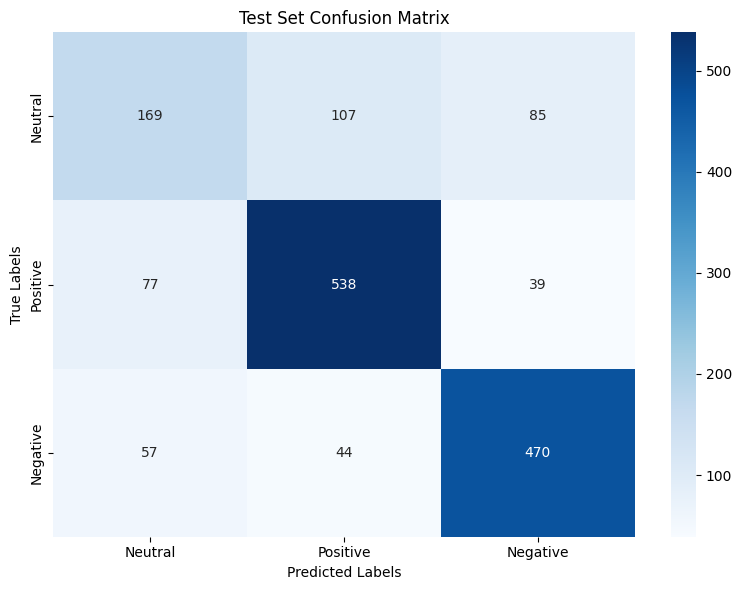

In [8]:
import os
import random
import torch
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed()

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, val_df, test_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({"text": df["Data"], "label": df["Label"]}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df),
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[l] for l in x["label"]]}, batched=True)

# Tokenization
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).rename_column("label", "labels")
dataset.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Model init
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_list)
    )

# Training arguments for search (minimal settings)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
)

# Hyperparameter space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "polynomial"]),
    }

# Trainer for Optuna search
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Hyperparameter tuning
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=10,
)

# Final training arguments
best_training_args = TrainingArguments(
    output_dir="./best_results",
    save_strategy="epoch",
    save_total_limit=1,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
    **best_run.hyperparameters,
)

# Final trainer with best setup (no early stopping)
final_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Train
final_trainer.train()

# Validation results
val_results = final_trainer.evaluate()
print("Validation Results:", val_results)

# Test prediction
test_output = final_trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_preds, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
